# Inter-subject Representational Similarity Analysis
*Written by Emily Finn & Luke Chang*

“Model-free” analyses that exploit the time-locked nature of a stimulus across subjects—e.g., inter-subject correlation (ISC; [Hasson et al., 2004](https://science.sciencemag.org/content/303/5664/1634?casa_token=T_9g7N-Xu0MAAAAA:m1i9AAa80QHe_pA3xosCV-ucWhdU-0RUKQHoBr07J-5M7iUt8Clqxv5JiCwmA_WkUjboRmeBQFiAcQ)) and related approaches—are a powerful way to analyze naturalistic neuroimaging data. 

These approaches use one subject’s brain activity as a model for a second subject’s brain activity, reasoning that as long as two subjects receive the same input at the same time, any shared variance must be due to stimulus processing. If you haven't already, be sure to check out the [ISC tutorial](http://naturalistic-data.org/features/notebooks/Intersubject_Correlation.html) that is part of this book.

However, while ISC and related approaches were traditionally developed to detect responses shared at the group level, we know that brain activity during naturalistic stimuli also shows interesting individual differences.

**Q: How can we use inter-subject approaches to study what is *different* across subjects, rather than what is common?**

One problem is that ISC by definition operates at the level of subject pairs, while traits and behaviors operate at the level of single subjects. So, how can we relate ISC (one measure per subject pair) to behavior (one measure per subject)?

**A. Representational similarity analysis!**

If we take our subjects-by-subjects ISC matrix to be a "brain similarity" matrix, we can construct a "behavioral similarity" matrix and use RSA to find brain regions where subjects who are more similar in their behavior are also more similar in their neural response. The basic idea behind this is illustrated in the figure below:

![isrsa](../images/isrsa/Fig1_multilayer_figure_R1.jpg)

**Fig. 1. Schematic of inter-subject representational similarity analysis.**
*From [Finn et al., 2020](https://www.sciencedirect.com/science/article/pii/S1053811920303153)*. Each subject (bottom layer) is associated with a behavioral score (middle layer) and a pattern of brain activity (top layer, e.g., a time series from a given brain region during naturalistic stimulation). The middle and upper layers depict weighted graphs obtained using the similarity matrices as adjacency matrices, where thicker lines indicate increased similarity between nodes (subjects). In IS-RSA, we construct pairwise (i.e, subject-by-subject) similarity matrices for the behavioral data and the brain data, then compare these matrices using a Mantel test. Thus, we can leverage inter-subject analysis methods such as ISC to detect shared structure between brain data and behavioral data. This figure is a modified version of Fig. 1 in [Glerean et al. (2016)](https://onlinelibrary.wiley.com/doi/full/10.1002/hbm.23084).

Let's watch a short video showing how inter-subject approaches can be more sensitive to phenotypic differences between individuals than other approaches for analyzing naturalistic data. We'll also see the motivation behind the IS-RSA approach.

[Emily Finn, PhD](https://esfinn.github.io) is an Assistant Professor at Dartmouth College. 

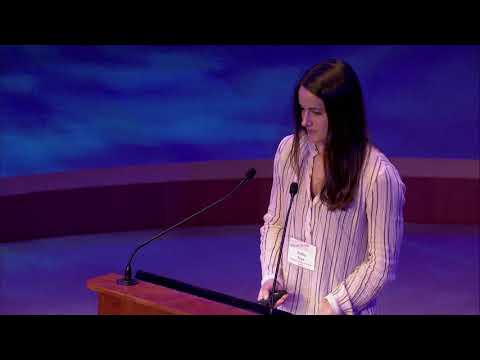

In [1]:
from IPython.display import YouTubeVideo

YouTubeVideo('vDrMuFJfsv8')

Next, let's watch another short video demonstrating an application of ISRSA using social network information. 

[Carolyn Parkinson, PhD](http://csnlab.org/) is an Assistant Professor at University of California Los Angeles and will discuss practical considerations for analyzing naturalistic data.

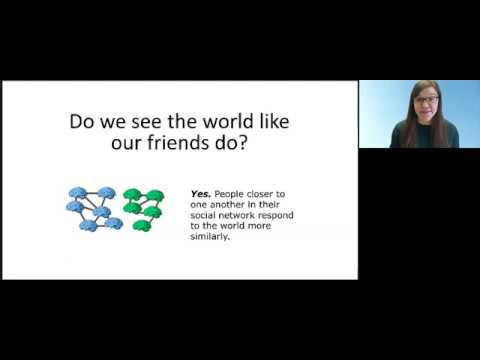

In [2]:
YouTubeVideo('roG9gkTOx_U')

## Getting Started
Before getting started with this tutorial, we need to make sure you have the necessary software installed and data downloaded.

### Software
This tutorial requires the following Python packages to be installed. See the [Software Installation](http://naturalistic-data.org/features/notebooks/Software.html) tutorial for more information.

- seaborn
- matplotlib
- numpy
- scipy
- sklearn
- pandas
- sklearn
- nltools
- nibabel
- nilearn
- datalad

Let's now load the modules we will be using for this tutorial.

In [3]:
import os
import glob
from pathlib import Path

import numpy as np
from scipy.stats import rankdata, ttest_rel, ttest_1samp

from matplotlib import pyplot as plt
import matplotlib.lines as mlines
import matplotlib.transforms as mtransforms

import pandas as pd
import seaborn as sns

import nibabel as nib
from nilearn.input_data import NiftiLabelsMasker
from nilearn.plotting import plot_glass_brain, plot_stat_map, view_img, view_img_on_surf

from nltools.data import Brain_Data, Adjacency
from nltools.mask import roi_to_brain, expand_mask
from nltools.stats import fdr, threshold

from sklearn.metrics import pairwise_distances
from sklearn.utils import check_random_state
from sklearn.manifold import TSNE

import datalad.api as dl

%matplotlib inline

### Data
This tutorial will be using the **Paranoia** dataset and will require downloading the extracted ROI timeseries  **csv** files. 

You will want to change `data_dir` to wherever you have installed the Paranoia datalad repository (e.g. `~/data`). We will initialize a datalad dataset instance and get the files we need for this tutorial. If you've already downloaded everything, this cell should execute quickly. See the [Download Data Tutorial](http://naturalistic-data.org/features/notebooks/Download_Data.html) for more information about how to install and use datalad.

Downloading all of the data could take a little while depending on the speed of your internet connection. Patience is a virtue :D

In [4]:
# data_dir = '/Volumes/Engram/Data/Paranoia'
data_dir = '/Volumes/Emily_MyPassport2TB/Paranoia/'

# If dataset hasn't been installed, clone from GIN repository
if not os.path.exists(data_dir):
    dl.clone(source='https://gin.g-node.org/ljchang/Paranoia', path=datadir)

# Initialize dataset
ds = dl.Dataset(data_dir)

# Get cropped & denoised nifti files for subject's 1's run 1 
result = ds.get(glob.glob(os.path.join(data_dir, 'fmriprep', '*', 'func', 'sub-tb2994*denoise_smooth6mm_task-story_run-1*nii.gz')))

# Get cropped & denoised node timeseries data for all subjects for all runs
result = ds.get(glob.glob(os.path.join(data_dir, 'fmriprep', '*', 'func', '*_nodeTimeSeries.csv')))

# Get participant demographic/behavioral file
result = ds.get(os.path.join(data_dir, 'participants.tsv'))


## ISRSA Analysis Tutorial
### Measuring similarity

How do we measure behavioral similarity? In choosing a distance metric, particularly when our behavior is one-dimensional (e.g., age ([Moraczewski et al., 2018](https://www.nature.com/articles/s41598-018-20600-0); [Richardson et al., 2018](https://www.nature.com/articles/s41467-018-03399-2)), a trait score ([Finn et al., 2018](https://www.nature.com/articles/s41467-018-04387-2)), accuracy on a cognitive task), we bake in some fundamental assumptions about the structure of the brain-behavior representational similarity that affect the ultimate results and how we interpret them. Also, there is some evidence that computing similarity using responses to individual questions as an embedding space can create a richer representational space than using univariate summary scores ([Chen et al., 2020](http://cosanlab.com/static/papers/Chen_2020_Neuroimage.pdf)). To get a feel for some potential structures, imagine arranging the rows and columns of the ISC matrix such that subjects are ordered by their behavioral score. What would we expect the resulting matrix to look like?

If we use Euclidean distance or another relative distance metric, we implicitly assume that subjects with closer scores should be more similar to one another, regardless of where they fall on the scale. In other words, for a behavior that is measured on a scale from 0 to 100, a pair of subjects scoring 0 and 1 should be just as similar as a pair of subjects scoring 99 and 100 (since in both cases, the Euclidean distance is 1). We call this the Nearest Neighbors (NN) model, since it assumes that a subject should always look most similar to his or her immediate neighbors, regardless of their absolute position on the scale.

The NN model may be appropriate for certain behaviors, but we could imagine an equally if not more plausible scenario: that similarity between subjects increases or decreases as one moves up or down the scale, in an absolute rather than relative sense. For example, perhaps high-scoring subjects are more similar to other high scorers, while low-scoring subjects are less similar both to high scorers and other low scorers. In other words, brain responses cluster together for subjects at one end of the behavioral spectrum, while variability increases as one moves toward the opposite end of the spectrum. We call this the Anna Karenina (or AnnaK) model, after the famous opening line of Leo Tolstoy’s novel, which reads “All happy families are alike; each unhappy family is unhappy in its own way” (or, in this context, “all high [low] scorers are alike; each low [high] scorer is different in his or her own way”). In this case, Euclidean distance would not be the most appropriate choice. Instead, we would want to model similarity using a metric that reflects absolute position on the scale—for example, mean: (i ​+ ​j)/2, minimum: min(i, j), or the product of the mean and minimum.

Let's do some simulations and visualizations to make this more concrete:

In [5]:
# First, choose number of subjects and simulate behavior chosen from random distribution
n_subs = 100
behav_raw = np.random.randn(n_subs)
behav = rankdata(behav_raw)-1

cmap = plt.cm.get_cmap('RdYlBu_r')
cmap.set_bad('#C0C0C0')

# Define some helper functions
def sort_square_mtx(mtx, vct):
    """
    Sorts rows/columns of a matrix according to a separate vector.
    """
    
    inds = vct.argsort()
    mtx_sorted = mtx.copy()
    mtx_sorted = mtx_sorted[inds, :]
    mtx_sorted = mtx_sorted[:, inds]
    
    return mtx_sorted

def scale_mtx(mtx):
    """
    Scales a matrix to have values between 0 and 1.
    """
    return (mtx-np.min(mtx))/(np.max(mtx)-np.min(mtx))

/opt/anaconda3/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:7: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. In future versions, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = copy.copy(mpl.cm.get_cmap("RdYlBu_r"))
  import sys


First, let's see what we're assuming the similarity structure should look like if we use Euclidean distance as our metric. The matrix below is subjects-by-subjects, with subjects ordered according to behavioral score (from low to high): 

Text(0.5, 1.0, 'Nearest neighbor\n(model: Euclidean distance(i,j))')

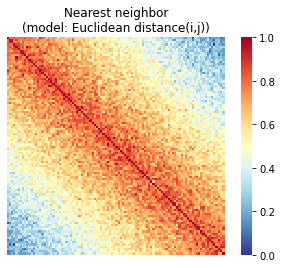

In [6]:
nn_mtx = np.zeros((n_subs, n_subs)) # initialize a similarity matrix
noise_factor = 0.1

for i in range(n_subs):
    for j in range(n_subs):
        if i < j:
            dist_ij = 1-(abs(behav[i]-behav[j])/n_subs) 
            dist_ij += np.random.randn()*noise_factor # add some random noise
            nn_mtx[i,j] = dist_ij
            nn_mtx[j,i] = dist_ij
            
nn_mtx = scale_mtx(nn_mtx)
np.fill_diagonal(nn_mtx, 1)    

fig, ax = plt.subplots()
sns.heatmap(sort_square_mtx(nn_mtx, behav), ax=ax, cmap=cmap, square=True, cbar=True, xticklabels=False, yticklabels=False)
ax.set_title("Nearest neighbor\n(model: Euclidean distance(i,j))")

So we can see that in the NN case, we see the highest similarity right along the diagonal. This means we're assuming that a subject should always look most similar to his or her immediate neighbors, regardless of where they fall on the scale more generally.

What about the "Anna K" case?

Text(0.5, 1.0, 'Anna Karenina\n(model: Euclidean distance(i,j))')

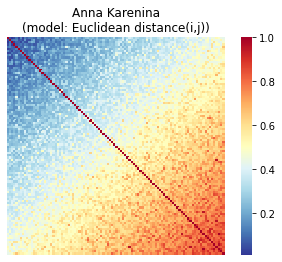

In [7]:
annak_mtx = np.zeros((n_subs, n_subs))
noise_factor = 0.1

for i in range(n_subs):
    for j in range(n_subs):
        if i < j:
            dist_ij = np.mean([behav[i]/n_subs, behav[j]/n_subs]) # calculate distance between i and j as 
            dist_ij += abs(np.random.randn()*noise_factor) # add some random noise
            annak_mtx[i,j] = dist_ij
            annak_mtx[j,i] = dist_ij

annak_mtx = scale_mtx(annak_mtx)
np.fill_diagonal(annak_mtx, 1)

fig, ax = plt.subplots()

# Draw heatmap
sns.heatmap(sort_square_mtx(annak_mtx, behav), ax=ax, cmap=cmap, square=True, cbar=True, xticklabels=False, yticklabels=False);
ax.set_title("Anna Karenina\n(model: Euclidean distance(i,j))")

Now we can see that similarity increases as we move down and to the right, meaning that we expect that high scorers will look similar to other high scorers, but low scorers won't look particularly similar to one another or to high scorers.

Another way to visualize the similarity structure of these matrices is to project them into a two-dimensional embedding using t-SNE (t-Distributed Stochastic Neighbor Embedding). In the righthand panels in the figure below, each dot represents a subject, and subjects are colored according to their behavioral score. In this embedding, similar observations (in this case, subjects) appear nearby, while dissimilar observations appear further away.

/opt/anaconda3/envs/py37/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:699: FutureWarning: 'square_distances' has been introduced in 0.24 to help phase out legacy squaring behavior. The 'legacy' setting will be removed in 1.1 (renaming of 0.26), and the default setting will be changed to True. In 1.3, 'square_distances' will be removed altogether, and distances will be squared by default. Set 'square_distances'=True to silence this warning.
  FutureWarning
/opt/anaconda3/envs/py37/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:699: FutureWarning: 'square_distances' has been introduced in 0.24 to help phase out legacy squaring behavior. The 'legacy' setting will be removed in 1.1 (renaming of 0.26), and the default setting will be changed to True. In 1.3, 'square_distances' will be removed altogether, and distances will be squared by default. Set 'square_distances'=True to silence this warning.
  FutureWarning


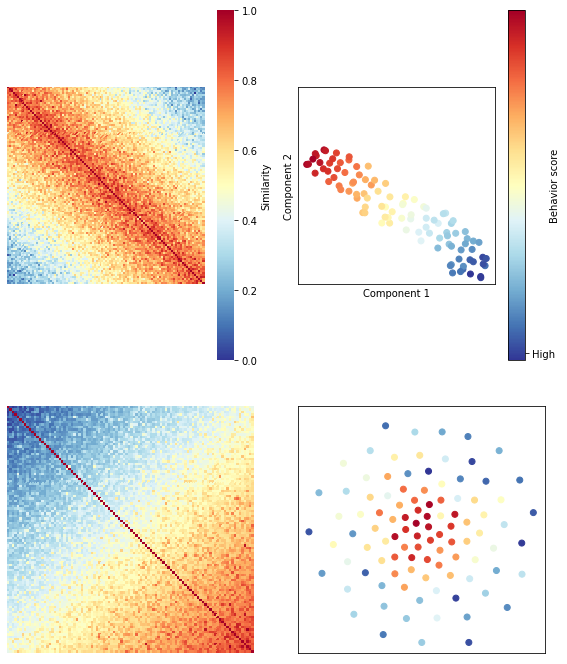

In [8]:
list_of_matrices = [nn_mtx, annak_mtx]

fig, axes = plt.subplots(len(list_of_matrices), 2, figsize = (8,10))

for m, mtx in enumerate(list_of_matrices):
    ax1 = axes[m, 0]
    ax2 = axes[m, 1]
    
    # Draw heatmap
    if m ==0:
        cbar = True
    else:
        cbar = False
        
    sns.heatmap(sort_square_mtx(mtx, behav), ax=ax1, 
                cmap=cmap, square=True, cbar=cbar, cbar_kws = {'label': 'Similarity'},
                xticklabels=False, yticklabels=False)
    
    # Draw tSNE plot
    # Note that TSNE operates on distance matrices, so because our simlarity matrices are already scaled 
    # to be between 0 and 1, we can convert easily by doing (1 – similarity matrix)
    isc_embedded = TSNE(n_components=2, metric="precomputed").fit_transform(1 - mtx) 
    scatter_p = ax2.scatter(isc_embedded[:,0], isc_embedded[:,1], c=behav, cmap=cmap)
    ax2.set_xticks([])
    ax2.set_yticks([])
    
    if m ==0:
        ax2.set_xlabel('Component 1')
        ax2.set_ylabel('Component 2')
        # cbar.ax2.set_xticklabels(['Low', 'High'])
        
    ax2.axis('square')
    ax2.set(xlim = ax2.get_xlim(), ylim = ax2.get_ylim())

cbar = fig.colorbar(scatter_p, ax = axes[0,1], ticks = [-2, 2])
cbar.ax.set_yticklabels(['Low', 'High'])
cbar.set_label('Behavior score', labelpad = -5)

plt.tight_layout()

OK, so we've seen using theory and simulations that we can apply RSA to subject-wise data, and that our choice of similarity/distance metric has implications for our underlying assumptions and how we interpret results.

How much does this matter in practice? Next we're going to walk through an example of how to apply IS-RSA to the Paranoia dataset.

### Behavioral Data

In this study, the main variable of interest was trait paranoia, which was measured using the Green et al. Paranoid Thoughts Scale A ([Green et al., 2008](https://www.cambridge.org/core/journals/psychological-medicine/article/measuring-ideas-of-persecution-and-social-reference-the-green-et-al-paranoid-thought-scales-gpts/4FDC2275DF3AE6D44BF86C60AEF84CE5)). This is a self-report questionnaire that asks participants to rate how strongly they agree with statements relating to paranoid ideation over the last month. Some examples are: "*I spent time thinking about friends gossiping about me*", "*People have been dropping hints for me*", and "*I was frustrated by people laughing at me.*" There are 16 items and each item is rated on a scale from 1 (not at all) to 5 (totally). Therefore, the minimum possible score is 16 and the maximum possible score is 80.

(Note that if you're interested in using this scale in future studies, a revised version, the [R-GPTS](https://www.cambridge.org/core/journals/psychological-medicine/article/revised-green-et-al-paranoid-thoughts-scale-rgpts-psychometric-properties-severity-ranges-and-clinical-cutoffs/1386D29D50A94FD3F2F17A56B3C5D368), has since been released.)

This was a sample of all healthy participants -- that is, no one had a diagnosis of schizophrenia or other mental illness -- so we expect most scores to be on the lower end of the spectrum. Still, trait paranoia varies even among the general population, and this study was designed to look at how normative variation in this trait relates to brain responses to an ambiguous social narrative.

(A quick aside: Measuring traits is notoriously difficult, and self-report suffers from a number of issues. Many people are working on better ways to phenotype individuals, such as using behavior [e.g., task performance] assessments, sometimes in conjunction with computational models . However, these trait measures are still commonly used. So, while we should take them with a large grain of salt, they can still be a useful starting point. We note that ISRSA can be used with any type of subject level data including behavioral data ([Chen et al., 2020](http://cosanlab.com/static/papers/Chen_2020_Neuroimage.pdf)), or a computational model ([van Baar et al., 2019](https://www.nature.com/articles/s41467-019-09161-6)).

First let's read in the table that contains demographic and behavioral info on our participants:

In [9]:
behav_data = pd.read_csv(os.path.join(data_dir, 'participants.tsv'), sep='\t')
behav_data.head()

,participant_id,age,sex,gptsa_score
0,sub-tb2994,27,M,22
1,sub-tb3132,28,F,16
2,sub-tb3240,25,M,18
3,sub-tb3279,20,M,20
4,sub-tb3512,34,M,18


Now let's generate a histogram to inspect the distribution of the GPTS-A scores.

/opt/anaconda3/envs/py37/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='gptsa_score', ylabel='Density'>

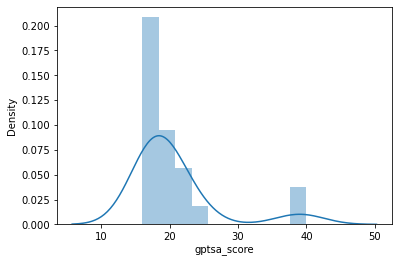

In [10]:
behav = behav_data["gptsa_score"]

sns.distplot(behav)

You can see that GPTS-A scores follow a pretty skewed distribution in our sample of 22 participants, with most participants scoring fairly low and only a couple scoring higher. This is not necessarily ideal, but it's also not uncommon for a scale like this. For some analyses, we might be worried about these two extreme values driving some or all of our effects, but in RSA it's common to use rank-based similarity metrics (i.e., Spearman correlation instead of Pearson). This means that subjects are not their absolute score, but rather their rank relative to other subjects, meaning that these two extreme scorers will not be overweighted. You can think of our behavior as following a uniform distribution of ranks between 1-22 (with some ties where 2 or more subjects had the same raw score):

/opt/anaconda3/envs/py37/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


<AxesSubplot:ylabel='count'>

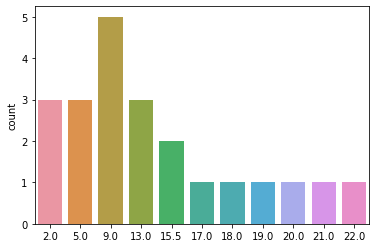

In [11]:
behav_rank = rankdata(behav)

sns.countplot(behav_rank)

### Brain Data

In working with fMRI data, we have a choice as to whether we'd like to work in the original resolution of the data -- voxels -- or if we'd like to summarize across space in some way ([Jolly & Chang, Under Review](https://osf.io/4exrn/?show=view)). We could calculate similarity across the whole brain at once, but there are probably some regions where the representational similarity with behavior is stronger than in other regions, and we'd like to be able to visualize and say something about which regions are contributing most to our effect. We could calculate similarity at each individual voxel separately. This has the advantage of maximizing spatial specificity, but it's also expensive in terms of time and computation, and we know the BOLD response tends to be smoother than single voxels. Another option would be to take a searchlight approach, where we calculate similarity within a "searchlight", or a relatively small sphere or cube of voxels centered around a voxel. This preserves some degree of spatial specificity while boosting signal relative to single voxels (which can be noisy) and recognizing the inherent smoothness of the local BOLD response, but it still requires us to loop through every voxel, which takes a lot of time and memory. Furthermore, both single-voxel and searchlight approaches also lead to larger penalties when it comes time to correct for multiple comparisons, since we've effectively done as many tests as there are voxels, and we need to stringently control for false positives.

A happy medium is to summarize voxelwise data into nodes, or parcels. In this approach, we used predefined ROIs to group voxels into contiguous regions. At each TR, we average signal in all the voxels in a node to get one representative timecourse for that node. This way, we cut down on computational complexity by several orders of magnitude (compare ~70,000 brain voxels in a typical 3mm<sup>3</sup> whole-brain acquisition with ~100-300 nodes found in most parcellations).

For purposes of this tutorial, we'll take the nodewise approach. We'll use a functional parcellation called the Shen atlas ([Shen et al., 2013](https://www.sciencedirect.com/science/article/abs/pii/S1053811913005818)), which has 268 nodes. I personally like this parcellation because it covers the whole brain including the subcortex and cerebellum, whereas many other parcellations only cover cortex. Also, in general, parcellations in the 200-300 node range provide a good balance of spatial specificity without having nodes so small that they amplify registration errors and partial voluming effects from slight misalignments across subjects. In general, though, we don't believe there is necessarily one "true" parcellation -- we see it more as a data-reduction step, and it's never a bad idea to make sure your results are robust to the choice of parcellation.

Another thing to note is that while using parcellations is convenient for computational purposes, this approach may obscure finer-grained individual differences that emerge when considering smaller spatial scales. [Feilong et al. (2018)](https://www.sciencedirect.com/science/article/pii/S1053811918307274?via%3Dihub) used an IS-RSA approach to quantify the reliability of individual differences in cortical functional architecture across alignment methods, spatial scales, and functional indices, and found that individuals reliably differ in fine-scale cortical functional architecture when data were first hyperaligned. (Check out our tutorial on [Functional Alignment](http://naturalistic-data.org/features/notebooks/Functional_Alignment.html) to learn more about hyperalignment and other approaches to functionally align data across subjects.) Furthermore, these individual differences in fine-grained cortical architecture provide strong predictions of general intelligence (see preprint [here](https://www.biorxiv.org/content/10.1101/2020.06.06.138099v1)). We believe that combining functional alignment with IS-RSA approaches is a promising avenue for future work to strengthen our understanding of brain-behavior relationships.

### Applying a parcellation mask and calculating nodewise timeseries

First, let's load our parcellation image and initialize a "masker" object from nilearn that will allow us to average voxels each individual node:

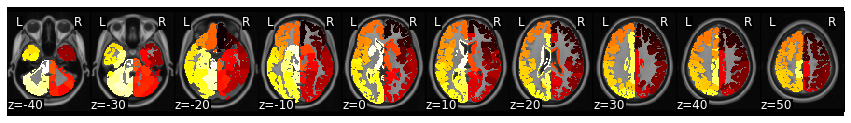

In [12]:
mask = Brain_Data('https://neurovault.org/media/images/8423/shen_2mm_268_parcellation.nii.gz')
mask.plot()

masker = NiftiLabelsMasker(labels_img=mask.to_nifti(), standardize=True)

Let's try this on the first run from the first subject to see if it's working as expected:

(526, 268)


<AxesSubplot:>

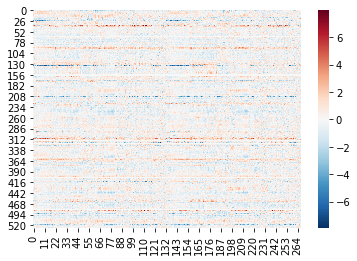

In [13]:
sub = 'sub-tb2994'
fmri_file = os.path.join(data_dir, 'fmriprep', sub, 'func', f'{sub}_denoise_smooth6mm_task-story_run-1_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz')

time_series = masker.fit_transform(fmri_file)
print(time_series.shape)

sns.heatmap(time_series, cmap='RdBu_r')

The array has the correct shape: 526 TRs (the length of run 1) x 268 nodes. When we visualize it as a heatmap we can see that the values look reasonable: centered around 0 (which we would expect given that the masker function normalizes the data by default), and no stripe-y artifacts that look *too* concerning.

Next, we'll create node time series for all subjects for all runs. There are 22 subjects, each with 3 runs, so this will take a little while (~45 min). To speed this up, we have already run the code and shared the extracted csv files in the datalad repository. If you would like to run this yourself, make sure you have the correct data downloaded and paste this code into a new cell and run it. 

```python
subj_list = behav_data["participant_id"]

for subj in subj_list:    
    for run in [1, 2, 3]:
        time_series_fname = os.path.join(data_dir, 'fmriprep', subj, 'func', f'{subj}_run-{run}_nodeTimeSeries.csv')
        if os.path.exists(time_series_fname):
            print(f"Node time series file for {subj}, run {run} already exists!")
        else:
            print(f"Creating node time series for {subj}, run {run}")
            time_series = masker.fit_transform(os.path.join(data_dir, 'fmriprep', subj, 'func', f'{subj}_denoise_smooth6mm_task-story_run-{run}_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz'))
            pd.DataFrame(time_series).to_csv(time_series_fname, index=False)

```

Now the next time we want to work with this data, we can just load these text files containing the nodewise timeseries. As we load them, we stack them into a 3d array that is subjects x TRs x nodes.

In [14]:
subj_list = behav_data["participant_id"]

data = []
for subj in subj_list:
    sub_data = []
    for run in range(1,4):
        sub_data.append(pd.read_csv(os.path.join(data_dir, 'fmriprep', subj, 'func', f'{subj}_run-{run}_nodeTimeSeries.csv')))
    sub_data = pd.concat(sub_data)
    data.append(sub_data.values)
data = np.array(data)

Let's make sure our data has the expected shape:

In [15]:
data.shape

(22, 1310, 268)

22 subjects x 1310 TRs (which is the number of timepoints in across all runs) x 268 nodes -- looks good.

Let's save those dimensions so we can continue to use them throughout our analysis:

In [16]:
n_subs, n_ts, n_nodes = data.shape

### Calculate brain similarity

Now that we've loaded the fMRI data for each subject, we want to compute similarity between each pair of subjects. We'll use inter-subject correlation (ISC) as our measure of brain similarity. ISC, originally proposed by Hasson et al. ([2004](https://science.sciencemag.org/content/303/5664/1634?casa_token=3oVmG98qSHgAAAAA:LXmtpfYQkGXP5GNuejgi1PpFRqrsBb0eC_jixgG_ezQt4Jnd_aEPhE9ZO6KO_lMIeSoW2vUK_T7iBw)), is the Pearson correlation of activity in the same spatial location across two or more subjects. Because all subjects heard the same time-locked story, any correlated activity across brains likely reflects processing of the stimulus.

Keep in mind that, in theory, we could calculate brain similarity based on any type of information we can extract from single subjects’ neuroimaging data. For example, we could use functional connectivity ([Glerean et al., 2016](https://onlinelibrary.wiley.com/doi/full/10.1002/hbm.23084)), or compare subjects’ temporal trajectories over the course of a stimulus using low-dimensional topological embeddings (e.g., [Gonzalez-Castillo et al., 2019](https://www.sciencedirect.com/science/article/pii/S1053811919307207?casa_token=5T27kc403nYAAAAA:N1AOdnwOScPcbvf5iIB8h6kN55DRGibCP6XsrOWell4KSIMCo6FDXAxnTX2K59jQXSxHoAtfkA); [Saggar et al., 2018](https://www.nature.com/articles/s41467-018-03664-4)), latent state discovery ([Chang et al., 2018](https://www.biorxiv.org/content/10.1101/487892v1.abstract)), or projection into a higher-order space using recurrent neural networks ([Venkatesh et al., 2019](https://www.sciencedirect.com/science/article/pii/S105381191832086X?casa_token=QTC-yPNogCoAAAAA:uMb-Hek05cjMAlRJ6msHKC3cwYQU1QuP9TSQaBky8iuLxsHt6Tr5RVkohw4SGPo2GZCrGeoQ8A)). These are all really interesting potential extensions of IS-RSA. For now, we'll use ISC because it is straightforward to compute, visualize, and interpret.

We'll calculate one ISC matrix (with dimensions subjects x subjects) for each of our 268 nodes. We use the `pairwise_distances` from scikit-learn to compute the distance matrix as it is much faster than `np.corrcoef` and can compute many different types of distance. When we use correlation, we can easily convert it into similarity by subtracting the values from 1. We also store the similarity/distance matrices in an `nltools.data.Adjacency` instance to make it easier to perform operations on the matrix.

In [17]:
similarity_matrices = []
for node in range(n_nodes):
    similarity_matrices.append(Adjacency(1 - pairwise_distances(data[:, :, node], metric='correlation'), matrix_type='similarity'))
similarity_matrices = Adjacency(similarity_matrices)

Let's visualize one of these matrices to make sure it looks reasonable:

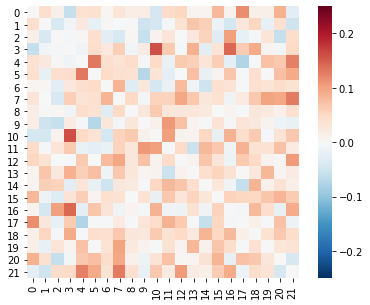

In [18]:
similarity_matrices[0].plot(vmin=-.25, vmax=.25, cmap='RdBu_r')

This looks reasonable: most values are positive, and there is some variance in correlation strength across subject pairs. (We are ignoring the diagonal is since each subject is perfectly correlated with him or herself.)
    
Before diving into this variability across subject pairs and how it relates to behavior, we might want to see which nodes show the highest ISC across the whole group. We will compute the *mean* (or median) of the lower triangle of the matrix using the `Adjacency.isc` method. We could also get the p-values using the subject-wise bootstrapping method ([Chen et al., 2016](https://www.sciencedirect.com/science/article/pii/S1053811916301331)), but it takes a little bit longer to compute as each ROI needs to be run about 5,000 times. To make the code more concise, we run this using a dictionary comprehension, which is like an inplace for loop that creates a Python dictionary. See the [ISC tutorial](http://naturalistic-data.org/features/notebooks/Intersubject_Correlation.html) for a more in depth overview of the nuances of computing ISC.

In [19]:
isc = {node:similarity_matrices[node].isc(metric='mean', n_bootstraps=1, n_jobs=1)['isc'] for node in range(n_nodes)}

In [20]:
expand_mask(mask)

nltools.data.brain_data.Brain_Data(data=(268, 238955), Y=0, X=(0, 0), mask=MNI152_T1_2mm_brain_mask.nii.gz, output_file=[])

We can combine the ISC values with the Shen k=268 mask to plot the ISC values on the brain. The `nltools.mask.roi_to_brain` function needs an array of ISC values in an order that corresponds to an image with a binary mask for each ROI. We can quickly create that using the `nltools.mask.expand_mask` function. Finally, we can plot the results using any of the `nilearn` plotting functions by casting our `Brain_Data` instance back into a `nibabel` instance with the `.to_nifti()` method.

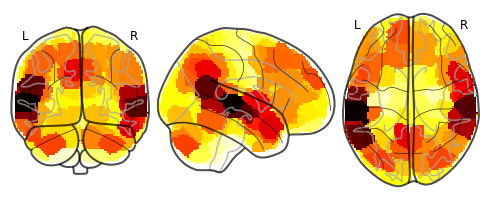

In [21]:
isc_brain = roi_to_brain(pd.Series(isc), expand_mask(mask))

plot_glass_brain(isc_brain.to_nifti())

It looks like the highest synchrony was in superior temporal cortex, which makes sense given that these areas are involved in auditory processing and language. Visual regions aren't particularly synchronized, which also makes sense, since this was a purely audio story. But there is also some interesting synchrony in the temporo-parietal junction, anterior temporal lobe, parts of prefrontal cortex, and posterior cerebellum. This may be a hint that above and beyond receiving the same low-level auditory and linguistic input, participants' higher-level processing of the stimulus may have been somewhat similar as well.

OK, that was a good sanity check, but what we really want to know is not where there's high ISC overall, but where ISC is higher among pairs of participants that are also more similar in their behavior score.

### Calculate behavioral similarity

As discussed above, there are multiple ways to calculate behavioral similarity, and the metric we choose both implies something about our assumptions for what the similarity structure should look like and affects how we interpret the results.

Let's extract our vector of scores for the behavior we're interested in.

In [22]:
behav = behav_data["gptsa_score"]
behav_rank = rankdata(behav) # explicity convert the raw scores to ranks

We're going to explore both types of similarity structures presented above (nearest-neighbors and Anna Karenina) to see which one is a better fit for our data.

We'll start by calculating the "nearest neighbors" behavioral similarity matrix. The metric for this is Euclidean distance, or just the difference between two subjects' ranks. While RSA operates equally well on similarity and distance matrices, I personally find it a bit easier to keep things straight when both matrices are of the same type. Because ISC is inherently a similarity measure (higher scores = more similar), and Euclidean distance is inherently a distance measure (higher scores = more distant/less similar), we'll convert the Euclidean distances to similarities using the `Adjacency.distance_to_similarity` method. This makes it more straightforward later on, when we can interpret positive RSA _r_ values as reflecting a higher representational similarity between brain and behavior.

Text(0.5, 1.0, 'Behavioral similarity matrix after sorting')

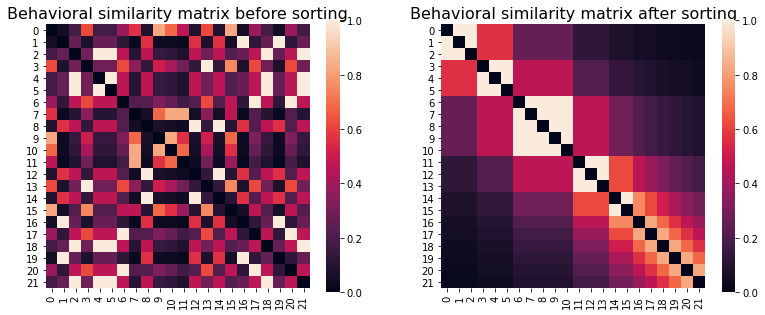

In [23]:
behav_sim_nn = Adjacency(pairwise_distances(np.reshape(behav_rank, (-1, 1)), metric='euclidean'), matrix_type='distance')
behav_sim_nn = behav_sim_nn.distance_to_similarity()

fig, (ax1, ax2) = plt.subplots(1,2, figsize=(13,5))
behav_sim_nn.plot(axes=ax1)
ax1.set_title("Behavioral similarity matrix before sorting", fontsize=16)

sns.heatmap(sort_square_mtx(behav_sim_nn.squareform(), behav), ax = ax2, square=True)
ax2.set_title("Behavioral similarity matrix after sorting", fontsize=16)

We can see that after sorting subjects in order of paranoia score rank (from low to high), the expected diagonal structure -- where each subject is more similar to his/her immediate neighbors -- becomes clearly visible. However, note that this matrix is **only** for purposes of visualization: for our IS-RSA analyses, we'll want to use the original matrix to make sure that the subject order matches our brain similarity (ISC) matrices!

Now we'll construct a behavioral similarity matrix reflecting the "Anna Karenina" structure. The metric for this is the mean of two subjects' ranks, which we'll normalize by the highest possible rank (the number of subjects):

Text(0.5, 1.0, 'Behavioral similarity matrix after sorting')

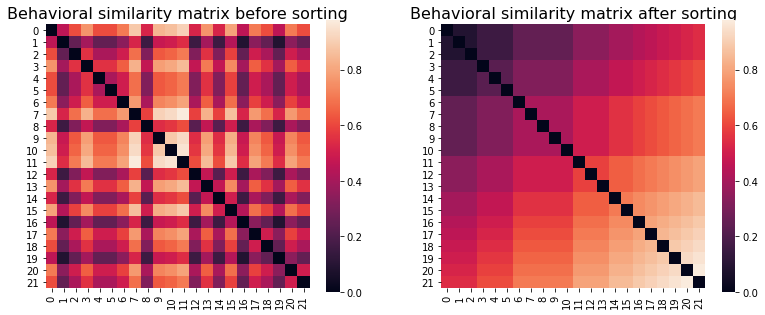

In [24]:
behav_sim_annak = np.zeros((n_subs, n_subs))

for i in range(n_subs):
    for j in range(n_subs):
        if i < j:
            sim_ij = np.mean([behav_rank[i], behav_rank[j]])/n_subs
            behav_sim_annak[i,j] = sim_ij
            behav_sim_annak[j,i] = sim_ij
        elif i==j:
            behav_sim_annak[i,j] = 1

behav_sim_annak = Adjacency(behav_sim_annak, matrix_type='similarity')

fig, (ax1, ax2) = plt.subplots(1,2, figsize=(13,5))
behav_sim_annak.plot(axes=ax1)
ax1.set_title("Behavioral similarity matrix before sorting", fontsize=16)

sns.heatmap(sort_square_mtx(behav_sim_annak.squareform(), behav), ax = ax2, square=True)
ax2.set_title("Behavioral similarity matrix after sorting", fontsize=16)

We can see the expected structure in the sorted similarity matrix: similarity increases as you move down and to the right, reflecting the idea that pairs of participants that score higher on trait paranoia should be more similar that pairs of low-scoring participants. 

One convenient feature of operationalizing the similarity matrix in this way is that that the same model can detect effects in both directions, based on the sign of the resulting r-value between the brain and behavioral similarity matrices. If high scorers are alike and low scorers different, the resulting r-value would be positive; if low scorers are alike and high scorers different, it would be negative. This means we don't have to run two different models to check for effects in different directions.

### Compute Intersubject Representational Similarity Analysis (IS-RSA)
Now that we have our similarity matrices for both brain and behavior data, we can do intersubject RSA!

Rather than finding the central tendency of the pairwise relationships, or the *reliability* of the signal, by computing the mean for ISC, we instead explore that structure of the variations in the pairwise relationships with IS-RSA. This is computed using representational similarity analysis, where we vectorize the lower triangle of the pairwise neural ISC and correlate it with the vectorized lower triangle of the pairwise behavioral ISC.  Because we don't necessarily assume that there will be a linear relatoinship, particularly as we using different distance metrics (i.e., correlation and euclidean distance), we typically use Spearman $\rho$ ranked correlations.

Let's loop over nodes and compute the similarity between the brain and each of the competing hypotheses reflected in the Nearest Neighbor and AnnaK similarity matrices.


In [25]:
isrsa_nn, isrsa_annak = {}, {}
for node in range(len(similarity_matrices)):
    isrsa_nn[node] = similarity_matrices[node].similarity(behav_sim_nn, metric='spearman', n_permute=1, n_jobs=1 )['correlation']
    isrsa_annak[node] = similarity_matrices[node].similarity(behav_sim_annak, metric='spearman', n_permute=1, n_jobs=1 )['correlation']

isrsa_nn_brain = roi_to_brain(pd.Series(isrsa_nn), expand_mask(mask))
isrsa_annak_brain = roi_to_brain(pd.Series(isrsa_annak), expand_mask(mask))

Just as we demonstrated above, we can plot the correlation values back on the brain using the `nltools.mask.roi_to_brain` function.

Now let's plot an axial montage of each of the ISRSA maps using the same colorscale to make it easier to compare the results across the two analyses.

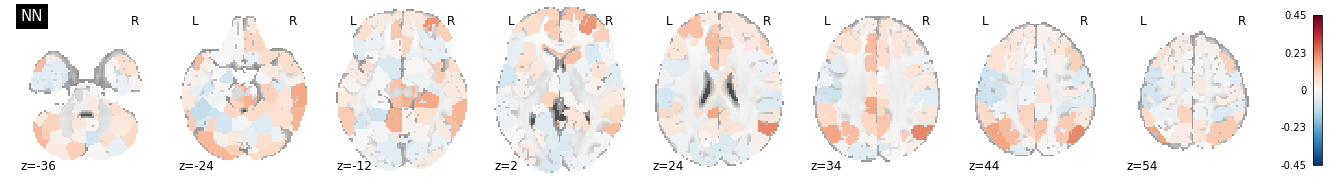

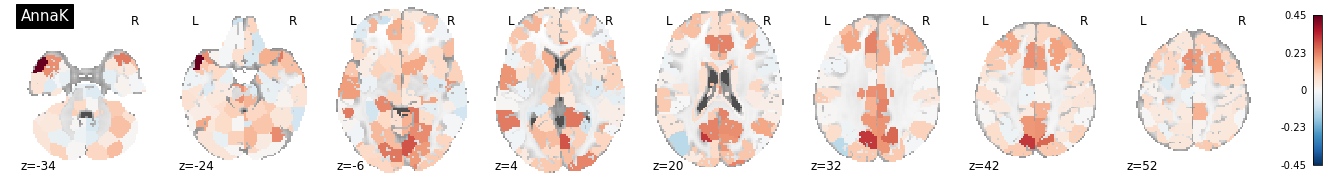

In [26]:
# Find the max absolute magnitude r_val across both sets of results so we can plot using the same colorscale
vmax = np.max(np.abs([list(isrsa_nn.values()), list(isrsa_annak.values())]))

plot_stat_map(isrsa_nn_brain.to_nifti(), display_mode='z', cut_coords=8, vmax=vmax, title = "NN", cmap='RdBu_r')
plot_stat_map(isrsa_annak_brain.to_nifti(), display_mode='z', cut_coords=8, vmax=vmax, title = "AnnaK", cmap='RdBu_r')

Interestingly, some of the nodes with the highest IS-RSA values for the nearest neighbor model are in the angular gyrus/temporo-parietal junction (a typical "default mode" region), and the lateral prefrontal cortex. The Anna Karenina model also has high IS-RSA values in the angular gyrus, but also in the PCC and dACC.

### Comparing different models
We can also look at the distribution of RSA r-values across all nodes, to see if there is generally some level of representational similarity between brain and behavior. We can test if the distribution is significantly shifted from zero using a one-sample t-test. Note that this doesn't tell us which, if any, individual nodes show significant representational similarity, but it can tell us if there is significant representational similarity at the whole-brain level.

Text(0.95, 5, 't=13.75, p = 0.000')

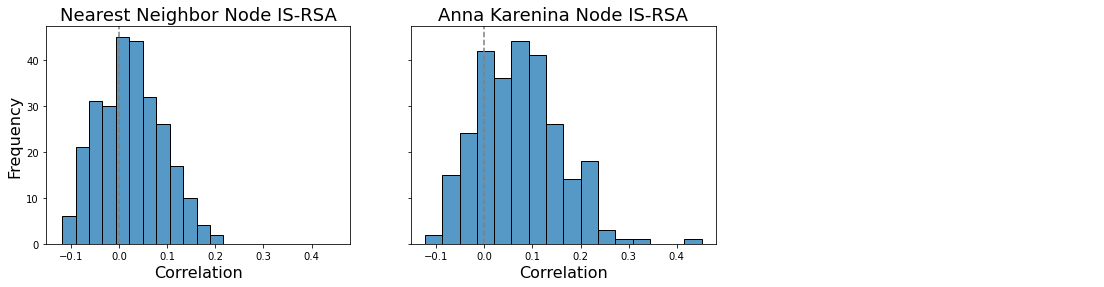

In [40]:
f, a = plt.subplots(ncols=2, figsize=(12,4), sharex=True, sharey=True)
sns.histplot(list(isrsa_nn.values()), ax=a[0])
a[0].axvline(0, color='gray', linestyle='--');
a[0].set_ylabel('Frequency', fontsize=16)
a[0].set_xlabel('Correlation', fontsize = 16)
a[0].set_title('Nearest Neighbor Node IS-RSA', fontsize=18)
t, p = ttest_1samp(list(isrsa_nn.values()), 0)
a[0].annotate(f't={t:.2f}, p = {p:.03f}', xy = (.2, 40),fontsize=16, color='gray')

sns.histplot(list(isrsa_annak.values()), ax=a[1])
a[1].axvline(0, color='gray', linestyle='--');
a[1].set_ylabel('Frequency', fontsize=16)
a[1].set_xlabel('Correlation', fontsize = 16)
a[1].set_title('Anna Karenina Node IS-RSA', fontsize=18)
t, p = ttest_1samp(list(isrsa_annak.values()), 0)
a[1].annotate(f't={t:.2f}, p = {p:.03f}', xy = (.2, 40),fontsize=16, color='gray')


We see that the values are generally shifted positive (the expected direction), meaning that there is more representational similarity between brain and behavior than we would expect by chance. 

We can also test if the mean of the two distributions are significantly different from each other using a paired-samples t-test.

t=-7.43, p = 0.000


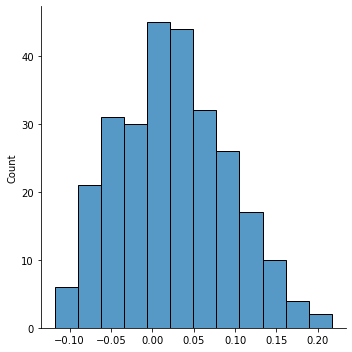

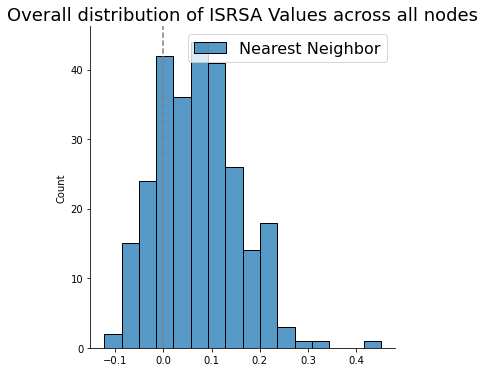

In [36]:
sns.histplot(list(isrsa_nn.values()))
sns.displot(list(isrsa_annak.values()))
plt.legend(['Nearest Neighbor', 'Anna Karenina'], fontsize=16)
plt.title('Overall distribution of ISRSA Values across all nodes', fontsize=18)
plt.gca().axvline(0, color='gray', linestyle='--');

t, p = ttest_rel(list(isrsa_nn.values()), list(isrsa_annak.values()))
print(f't={t:.2f}, p = {p:.03f}')

Another way to visually compare results from the two models is with a scatterplot. In the plot below, each dot is a node, and we also plot the identity line (where y = x, *not the regression line*). If the NN and AnnaK models gave identical results, all the dots would fall on this diagonal line. The fact that some dots are above and some dots are below means that different nodes are best fit by different models (some by NN, others by AnnaK). The fact that most of the dots are above (rather than below) the line means that overall, the AnnaK model is better for the majority of nodes.

Text(0, 0.5, 'AnnaK r value')

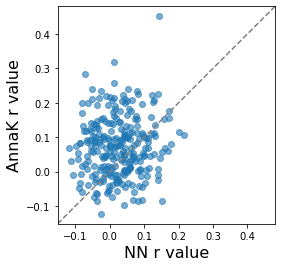

In [29]:
def set_aspect_ratio(ax):
    
    """
    helper function to make square axes with equal x and y ranges
    """
    
    xmin, xmax = ax.get_xlim()
    ymin, ymax = ax.get_ylim()
    both_min = np.min([xmin, ymin])
    both_max = np.max([xmax, ymax])
    ax.set_xlim((both_min, both_max))
    ax.set_ylim((both_min, both_max))
    x0,x1 = ax.get_xlim()
    y0,y1 = ax.get_ylim()
    ax.set_aspect(abs(x1-x0)/abs(y1-y0))
    
fig, ax = plt.subplots()

ax.scatter(list(isrsa_nn.values()), list(isrsa_annak.values()), alpha=.6)

line = mlines.Line2D([0, 1], [0, 1], color='gray', linestyle='--')
transform = ax.transAxes
line.set_transform(transform)
ax.add_line(line)
set_aspect_ratio(ax)
ax.set_xlabel("NN r value", fontsize=16)
ax.set_ylabel("AnnaK r value", fontsize=16)

### Hypothesis Tests
It's easy enough to calculate a correlation coefficient between the upper triangles of two similarity matrices, but we need to be careful when assessing the statistical significance of this correlation. Parametric p-values won't work here, since the values in each matrix are not independent: each value is associated with two subjects, meaning that any two values that share a row or column are not independent. In other words, the value for (*i,j*) is not independent from the value for (*i,k*), since they share subject *i*. 

This means that we need to calculate significance non-parametrically, by randomly shuffling one of the matrices in a way that respects this complicated dependence structure. We can do this by simply making sure we permute rows and columns at the same time. One easy way to think about this is, in the case of the behavioral similarity matrix, it's as if we shuffled behavior scores across subjects and recalculated the behavioral similarity matrix. (Or, in the case of the brain similarity matrix, it's as if we shuffled node timeseries across subjects and recalculated the ISC matrix.) Then we correlate this shuffled matrix with the second matrix, and we do this a large number of times to build up a distribution for the correlation we might expect by chance. 

We will use the `Adjacency.similarity` method again, but now we will specify the number of permutation with `n_permute=5000` and the number of CPUs to use with `n_jobs`. If `n_job=-1`, the function will parallieze the permutations using all available CPUs.

Note: running these permutation tests over all nodes for both models will take approximately 30 min as it requires running over 2.6 million correlations (2 models X 268 nodes X 5000 permutations).

In [30]:
isrsa_nn_r, isrsa_nn_p = {}, {}
isrsa_annak_r, isrsa_annak_p = {}, {}
for node in range(len(similarity_matrices)):
    if node==0:
        print("Doing node {} of {}...".format(node+1, len(similarity_matrices)), end =" ")
    else:
        print("{}..".format(node+1), end = " ")
    stats_nn = similarity_matrices[node].similarity(behav_sim_nn, metric='spearman', n_permute=5000, n_jobs=-1 )
    isrsa_nn_r[node] = stats_nn['correlation']
    isrsa_nn_p[node] = stats_nn['p']
    
    stats_annak = similarity_matrices[node].similarity(behav_sim_annak, metric='spearman', n_permute=5000, n_jobs=-1 )
    isrsa_annak_r[node] = stats_annak['correlation']
    isrsa_annak_p[node] = stats_annak['p']

isrsa_nn_r_brain = roi_to_brain(pd.Series(isrsa_nn_r), expand_mask(mask))
isrsa_nn_p_brain = roi_to_brain(pd.Series(isrsa_nn_p), expand_mask(mask))

isrsa_annak_r_brain = roi_to_brain(pd.Series(isrsa_annak_r), expand_mask(mask))
isrsa_annak_p_brain = roi_to_brain(pd.Series(isrsa_annak_p), expand_mask(mask))

Doing node 1 of 268... 2.. 3.. 4.. 5.. 6.. 7.. 8.. 9.. 10.. 11.. 12.. 13.. 14.. 15.. 16.. 17.. 18.. 19.. 20.. 21.. 22.. 23.. 24.. 25.. 26.. 27.. 28.. 29.. 30.. 31.. 32.. 33.. 34.. 35.. 36.. 37.. 38.. 39.. 40.. 41.. 42.. 43.. 44.. 45.. 46.. 47.. 48.. 49.. 50.. 51.. 52.. 53.. 54.. 55.. 56.. 57.. 58.. 59.. 60.. 61.. 62.. 63.. 64.. 65.. 66.. 67.. 68.. 69.. 70.. 71.. 72.. 73.. 74.. 75.. 76.. 77.. 78.. 79.. 80.. 81.. 82.. 83.. 84.. 85.. 86.. 87.. 88.. 89.. 90.. 91.. 92.. 93.. 94.. 95.. 96.. 97.. 98.. 99.. 100.. 101.. 102.. 103.. 104.. 105.. 106.. 107.. 108.. 109.. 110.. 111.. 112.. 113.. 114.. 115.. 116.. 117.. 118.. 119.. 120.. 121.. 122.. 123.. 124.. 125.. 126.. 127.. 128.. 129.. 130.. 131.. 132.. 133.. 134.. 135.. 136.. 137.. 138.. 139.. 140.. 141.. 142.. 143.. 144.. 145.. 146.. 147.. 148.. 149.. 150.. 151.. 152.. 153.. 154.. 155.. 156.. 157.. 158.. 159.. 160.. 161.. 162.. 163.. 164.. 165.. 166.. 167.. 168.. 169.. 170.. 171.. 172.. 173.. 174.. 175.. 176.. 177.. 178.. 179.. 180.. 181.. 182

Feel free to explore the IS-RSA values with the interactive plots. The values should be identical to the analyses run above. However, we now we have p-values to evaluate the likelihood we would observe these values by chance.

Nearest-Neighbor Model



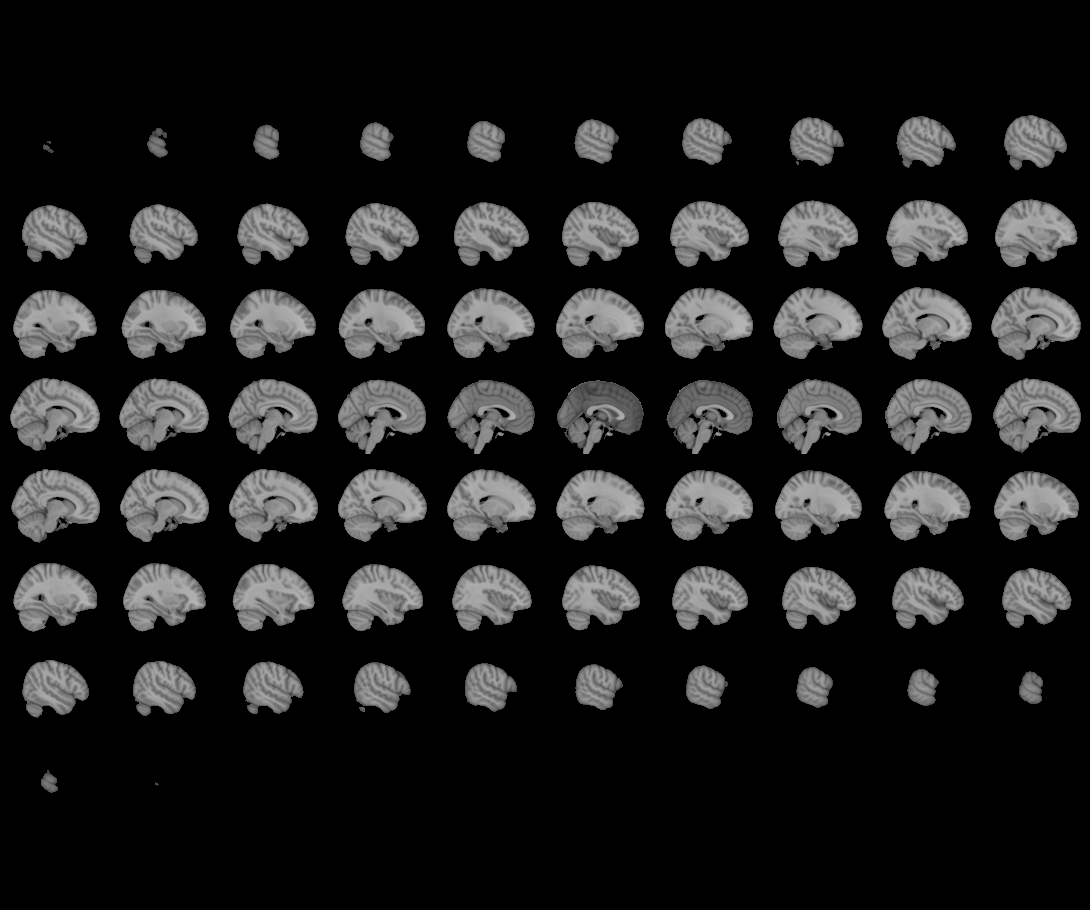
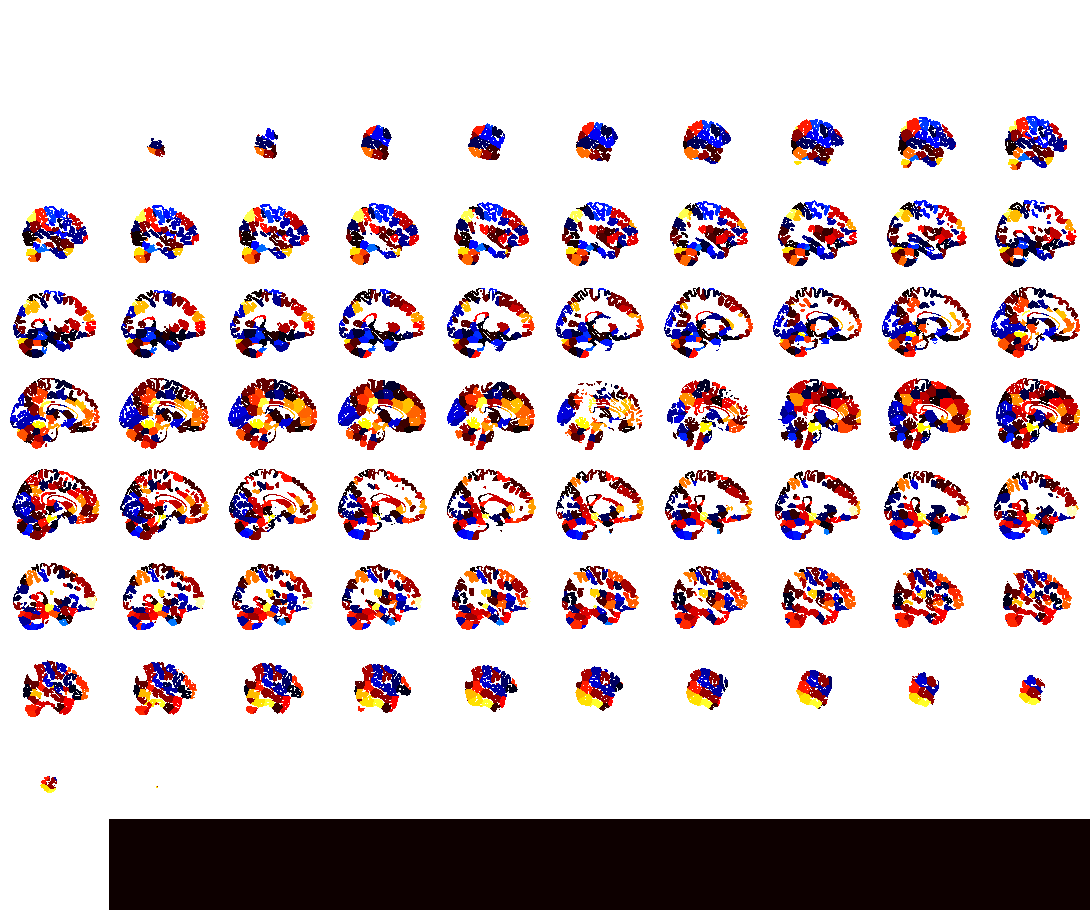

In [31]:
print('Nearest-Neighbor Model')
view_img(isrsa_nn_r_brain.to_nifti())

Anna Karenina Model



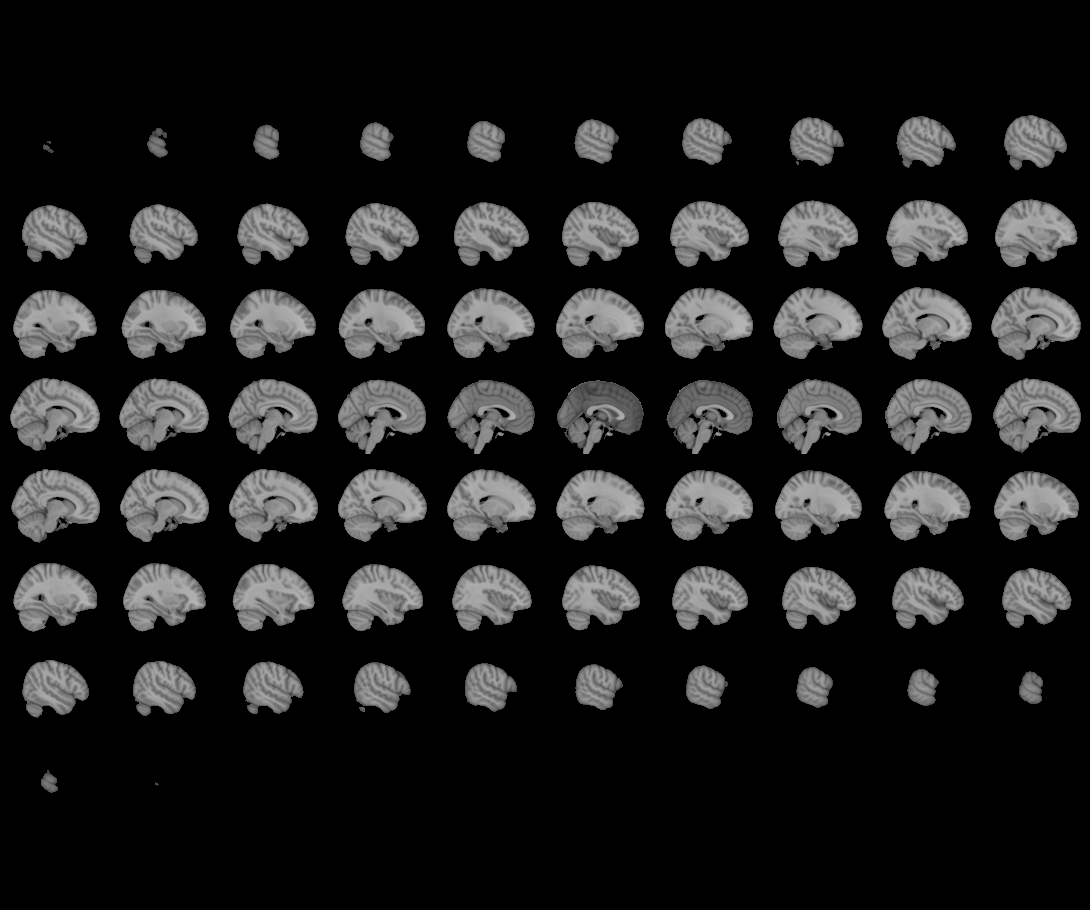
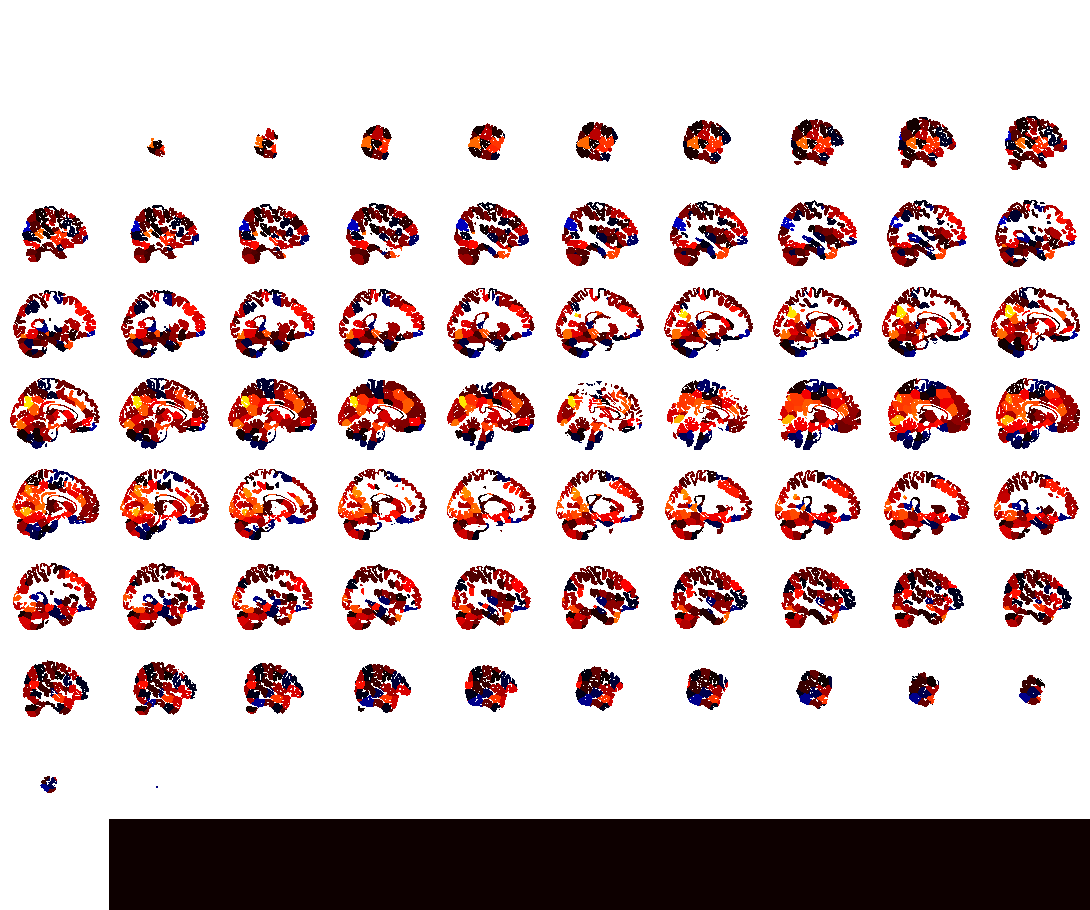

In [32]:
print('Anna Karenina Model')
view_img(isrsa_annak_r_brain.to_nifti())

#### Correcting for multiple comparisons
If we want to make inferences about the significance of representational similarity at individual nodes, we need to correct for multiple comparisons (since for each model we've run 268 tests -- one for each node). We could use Bonferroni correction, where we divide our alpha threshold (typically 0.05) by the number of tests we've run (268) to get a corrected alpha threshold (in this case 0.05/268 = 0.00019), but this is probably too conservative, resulting in many false negatives. An alternative is to use the false discovery rate method (FDR) to give us better power ([Benjamini & Hochberg, 1995](https://rss.onlinelibrary.wiley.com/doi/abs/10.1111/j.2517-6161.1995.tb02031.x)). For a more detailed tutorial about FDR, check out [DartBrains](https://dartbrains.org/features/notebooks/11_Thresholding_Group_Analyses.html)

First we'll do it for the results from the NN model:

FDR Threshold: -1


/opt/anaconda3/envs/py37/lib/python3.7/site-packages/nilearn/_utils/param_validation.py:70: UserWarning: The given float value must not exceed 0. But, you have given threshold=1e-06 
  threshold))
/opt/anaconda3/envs/py37/lib/python3.7/site-packages/nilearn/image/resampling.py:512: UserWarning: Casting data from int32 to float32
  warnings.warn("Casting data from %s to %s" % (data.dtype.name, aux))
/opt/anaconda3/envs/py37/lib/python3.7/site-packages/nilearn/plotting/find_cuts.py:63: UserWarning: Given img is empty. Returning default cut_coords=(0.0, 0.0, 0.0) instead.
  .format(DEFAULT_CUT_COORDS))



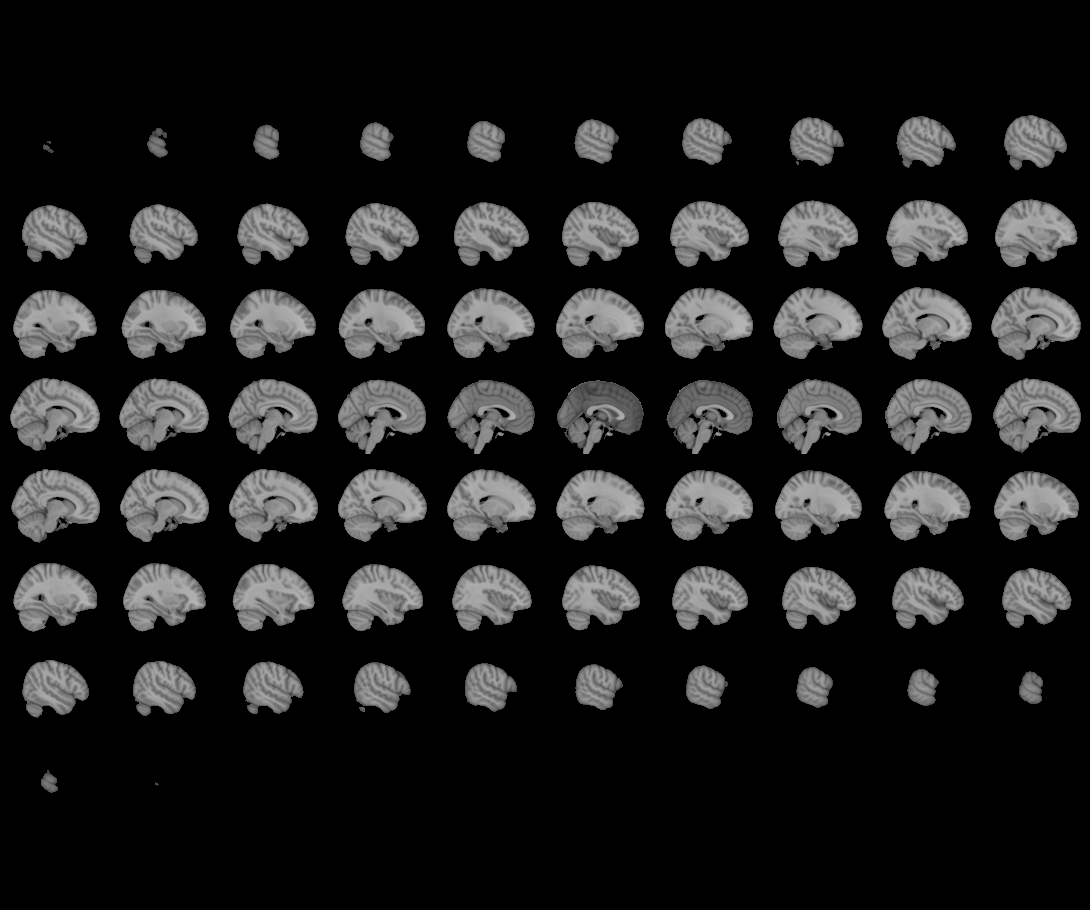
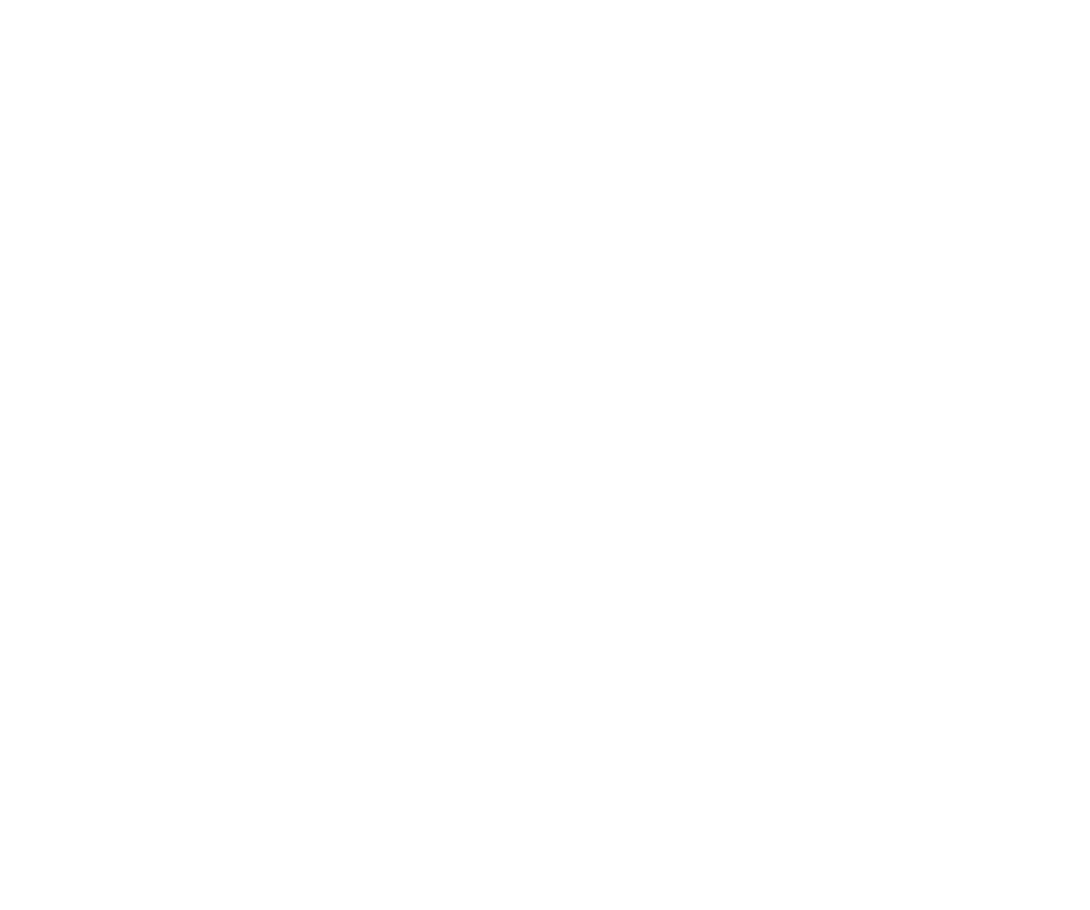

In [33]:
fdr_thr = fdr(pd.Series(isrsa_nn_p).values)
print(f'FDR Threshold: {fdr_thr}')

view_img(threshold(isrsa_nn_r_brain, isrsa_nn_p_brain, thr=fdr_thr).to_nifti())

As you can see the FDR threshold is fairly low, p < 0.0257. There are several nodes in the hippocampus, PCC, parietal cortex, cerebellum, and right lateral PFC that survive this threshold.

Let's see what survives multiple comparisons correction with the Anna Karenina model.

FDR Threshold: -1


/opt/anaconda3/envs/py37/lib/python3.7/site-packages/nilearn/_utils/param_validation.py:70: UserWarning: The given float value must not exceed 0. But, you have given threshold=1e-06 
  threshold))
/opt/anaconda3/envs/py37/lib/python3.7/site-packages/nilearn/image/resampling.py:512: UserWarning: Casting data from int32 to float32
  warnings.warn("Casting data from %s to %s" % (data.dtype.name, aux))
/opt/anaconda3/envs/py37/lib/python3.7/site-packages/nilearn/plotting/find_cuts.py:63: UserWarning: Given img is empty. Returning default cut_coords=(0.0, 0.0, 0.0) instead.
  .format(DEFAULT_CUT_COORDS))



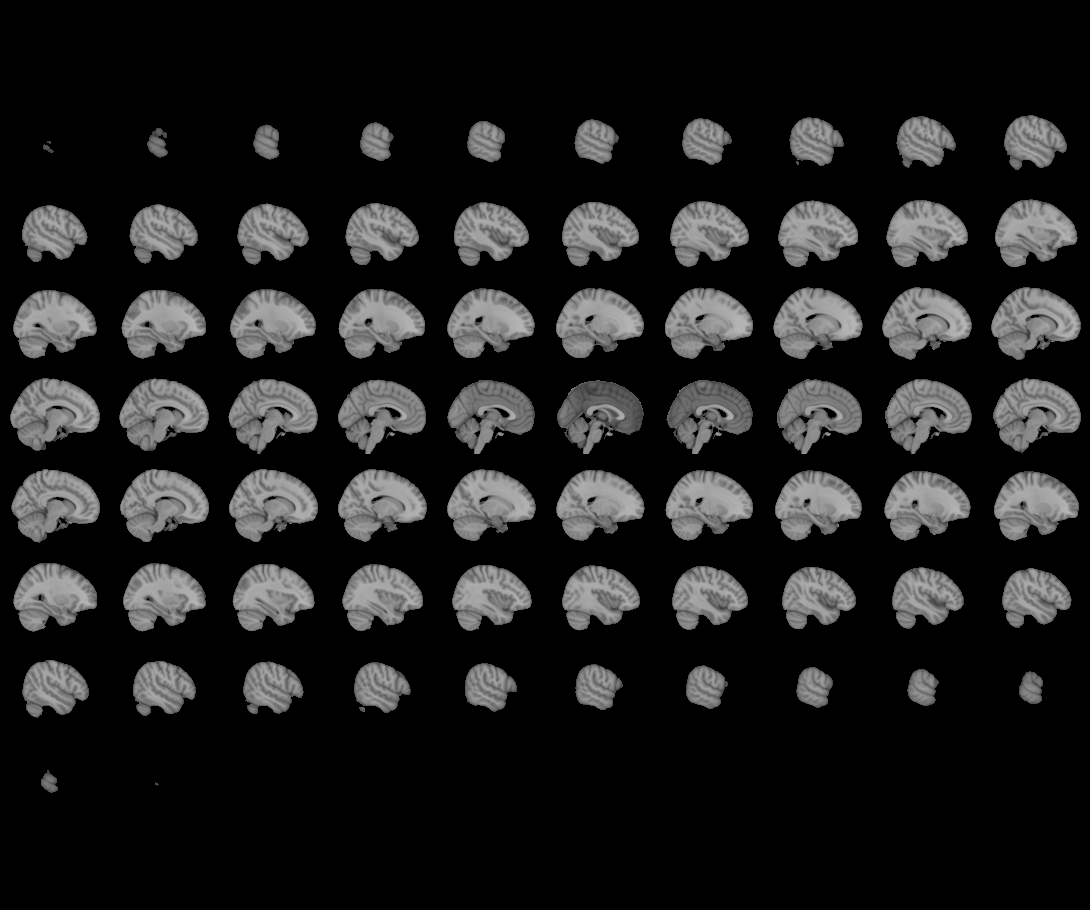
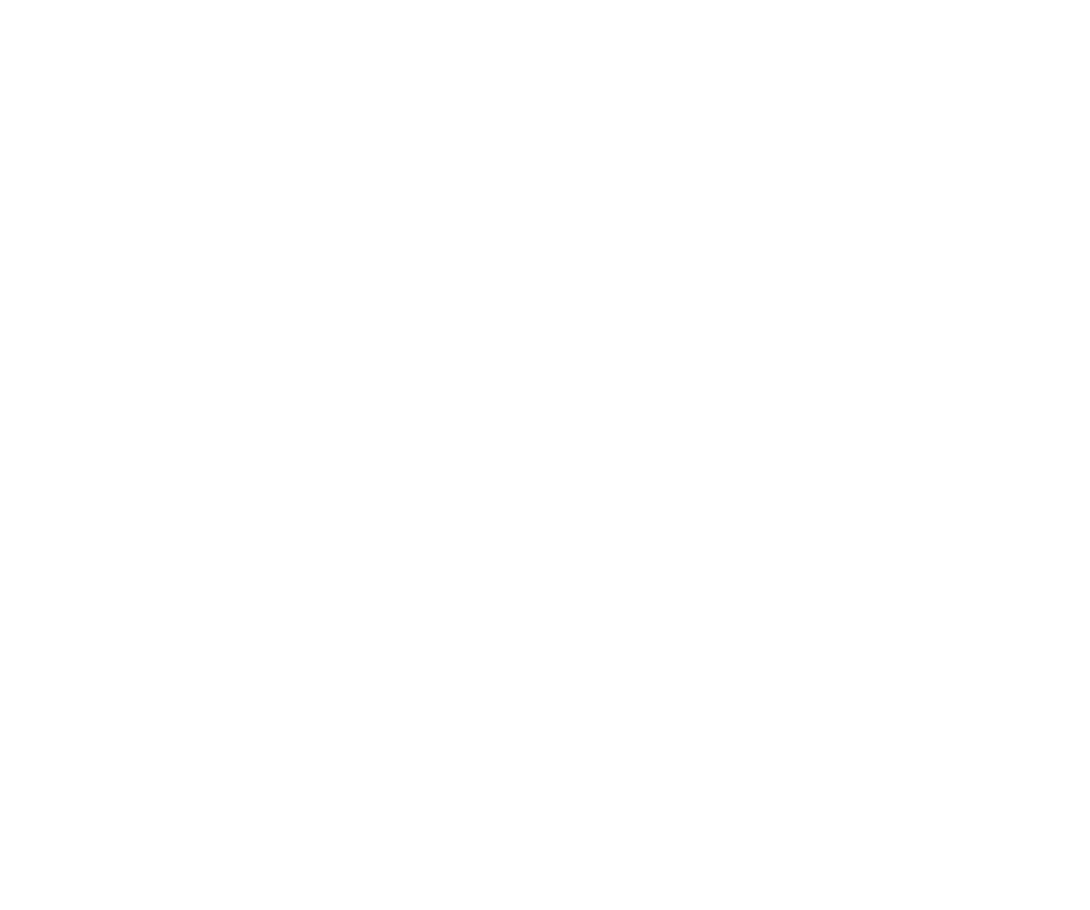

In [34]:
fdr_thr = fdr(pd.Series(isrsa_annak_p).values)
print(f'FDR Threshold: {fdr_thr}')

view_img(threshold(isrsa_annak_r_brain, isrsa_annak_p_brain, thr=fdr_thr).to_nifti())

Unfortunately it seems that no regions survive correction. Why might this be? It's likely a lack of power: with only 22 subjects, it's difficult to detect brain-behavior relationships.

In the [original paper](https://www.nature.com/articles/s41467-018-04387-2), we took a voxelwise approach, which greatly increased computational complexity -- and the number of tests -- but also allowed us to take advantage of cluster-based correction, which is another way to control the family-wise error rate that leverages the spatial structure of the data (based on the assumption that if many contiguous voxels are significant, it's unlikely to be due to chance). Here we elected to use a parcellation approach in order to keep computational costs lower, to enable more people to be able to run these analyses on their local computers. One tradeoff with using nodes is that we may lose sensitivity, and we are not able to use cluster correction or other spatial methods. 

In any case, we hope this has still been a useful discussion of the concepts behind inter-subject RSA and demonstration of how to apply this method to a real dataset. There are some publicly available datasets that include both naturalistic fMRI data and phenotyping data on larger numbers of subjects than what is available in the Paranoia dataset. These include:

- [Human Connectome Project 7T movie-watching data](https://www.humanconnectome.org/study/hcp-young-adult) (n = 184, four 15-minute movie-watching runs, many cognitive, affective, and clinical measures)
- [Child Mind Institute Health Brain Network project](http://fcon_1000.projects.nitrc.org/indi/cmi_healthy_brain_network/index.html) (n = 2,500+ and growing, two movie-watching runs [one 10-minute and one 3.5-minute], many cognitive, affective, and clinical measures)

If you know of others, please submit a pull request and add them here!

## Recommended Reading

Many of the ideas presented here come from this paper:
- [E. S. Finn, E. Glerean, A. Y. Khojandi, D. Nielson, P. J. Molfese, D. A. Handwerker, P. A. Bandettini. Idiosynchrony: From shared responses to individual differences during naturalistic neuroimaging. *NeuroImage,* 215, 2020](https://www.sciencedirect.com/science/article/pii/S1053811920303153)

If this tutorial was useful to you, please consider citing this paper in addition to the [naturalistic-data-analysis book](http://naturalistic-data.org/intro). Thanks!

Here are some other great resources for learning more about how RSA is generally used in brain imaging:
- [N. Kriegeskorte, M. Mur, P. Bandettini. Representational similarity analysis - connecting the branches of systems neuroscience. *Front. Syst. Neurosci.,* 2 (2008)](https://www.frontiersin.org/articles/10.3389/neuro.06.004.2008/full?utm_source=FWEB&utm_medium=NBLOG&utm_campaign=ECO_10YA_top-research)
- [N. Kriegeskorte, R.A. Kievit. Representational geometry: integrating cognition, computation, and the brain. *Trends Cognit. Sci.,* 17 (2013), pp. 401-412](https://www.sciencedirect.com/science/article/pii/S1364661313001277)
- [H. R. Dimsdale-Zucker, C. Ranganath. Chapter 27 - Representational Similarity Analyses: A Practical Guide for Functional MRI Applications, *Handbook of Behavioral Neuroscience,* Editor(s): Denise Manahan-Vaughan, Elsevier, Volume 28, 2018](https://www.sciencedirect.com/science/article/pii/B9780128120286000276)
- Luke Chang's [RSA tutorial](https://dartbrains.org/features/notebooks/14_RSA.html) for the [dartbrains project](https://dartbrains.org/intro)
- Mark Thornton's [lecture](https://www.youtube.com/watch?v=ufGtuT_J75w&index=29&t=0s&list=PLEE6ggCEJ0H0KOlMKx_PUVB_16VoCfGj9) and [tutorial](https://github.com/Summer-MIND/mind_2018/tree/master/tutorials/representational_similarity) at the [Methods in Neuroscience at Dartmouth (MIND) Summer School 2018](https://mindsummerschool.org/2018/07/30/narratives-and-naturalistic-contexts.html)

And here are some cool papers using IS-RSA methods:
- [van Baar, J.M., Chang, L.J. & Sanfey, A.G. The computational and neural substrates of moral strategies in social decision-making. Nat Commun 10, 1483 (2019).](https://www.nature.com/articles/s41467-019-09161-6)
- [David C. Gruskin, Monica D. Rosenberg, Avram J. Holmes. Relationships between depressive symptoms and brain responses during emotional movie viewing emerge in adolescence. NeuroImage, 216 (2020)](https://www.sciencedirect.com/science/article/pii/S1053811919308080)
- [P. A. Chen, E. Jolly, J. H. Cheong, . J. Chang. Intersubject representational similarity analysis reveals individual variations in affective experience when watching erotic movies. NeuroImage, 216 (2020)](https://www.sciencedirect.com/science/article/pii/S1053811920303372)
- [L. Nummenmaa, E. Glerean, M. Viinikainen, I. P. Jääskeläinen, R. Hari, M. Sams. Emotions promote social interaction by synchronizing brain activity across individuals. Proceedings of the National Academy of Sciences, Jun 2012, 109 (24) 9599-9604](https://www.pnas.org/content/109/24/9599.short)
- [Jääskeläinen, I., Pajula, J., Tohka, J. et al. Brain hemodynamic activity during viewing and re-viewing of comedy movies explained by experienced humor. Sci Rep 6, 27741 (2016).](https://www.nature.com/articles/srep27741)
- [S. Tei, J.-P. Kauppi, J. Fujino, K. F. Jankowski, R. Kawada, T. Murai, H. Takahashi. Inter-subject correlation of temporoparietal junction activity is associated with conflict patterns during flexible decision-making. Neuroscience Research, 144 (2019)](https://www.sciencedirect.com/science/article/pii/S016801021830244X)
- [M. Nguyen, T. Vanderwal, U. Hasson. Shared understanding of narratives is correlated with shared neural responses. NeuroImage, 184 (2019)](https://www.sciencedirect.com/science/article/pii/S1053811918307948)
- [Saalasti, S, Alho, J, Bar, M, et al. Inferior parietal lobule and early visual areas support elicitation of individualized meanings during narrative listening. Brain Behav. 2019; 9:e01288.](https://onlinelibrary.wiley.com/doi/full/10.1002/brb3.1288)
- [M. Bacha-Trams, Y. I. Alexandrov, E. Broman, E. Glerean, M. Kauppila, J. Kauttonen, E. Ryyppö, M. Sams, I. P. Jääskeläinen. A drama movie activates brains of holistic and analytical thinkers differentially. Social Cognitive and Affective Neuroscience, 13 (2018)](https://academic.oup.com/scan/article/13/12/1293/5168059)

## Contributions
 Emily Finn wrote the tutorial. Luke Chang edited text and code.